In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import lru_cache, reduce

In [121]:
@lru_cache()
def load_fake_names(fake_filename):
    """
    Just load the fake names, in tuple.
    """
    return tuple(pd.read_csv(fake_filename, index_col=0)['0'])


def fake_indices(scores, fake_names):
    """
    Calculate fake indices
    
    Parameters
    ----------
    scores: Scores of all the objects, including fakes at the end.
    
    fake_names: Tuple of fake object names.
    
    Return
    ------
    Table with 'name' and 'order' columns, sorted by 'order'.
    """
    fake_n = len(fake_names)
    index = np.argsort(scores)
    fake_index = np.argsort(index)[-fake_n:]  # Guess what's going on here ;)
    fake_table = pd.DataFrame({'order': fake_index, 'name': fake_names})
    return fake_table.sort_values(by='order').reset_index(drop=True)

def union_fakes(algo_to_fakes):
    """
    Union the different algorithms' fake detection curves to one
    """
    
    order = []
    for fake_table in algo_to_fakes.values():
        order.append(fake_table.sort_values(by='name')['order'].to_numpy())

    name = sorted(fake_table['name'])
    min_order = np.array(order).min(axis=0)

    table = pd.DataFrame({'order': min_order, 'name': name})
    table = table.sort_values(by='order').reset_index(drop=True)
    
    return table

<IPython.core.display.Javascript object>


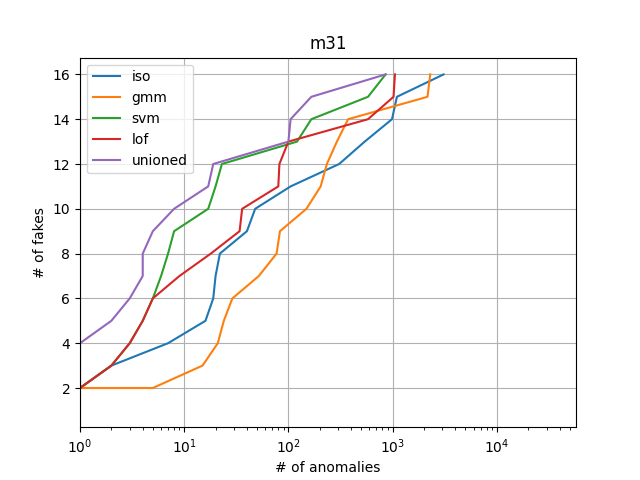

,iso,gmm,svm,lof,union
0,step,step,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,flat,MACHO-6.6696.60_format_R
2,Gaia16aye_3_format_r,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r
3,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r,flat_noise,flat
4,MACHO-6.6696.60_format_B,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r,Gaia16aye_2_format_r,Gaia16aye_3_format_r
5,ZTF18aaztjyd_format_r,Gaia16aye_format_r,MACHO-6.6696.60_format_B,MACHO-6.6696.60_format_B,flat_noise
6,Gaia16aye_format_r,MACHO-6.6696.60_format_B,flat,Gaia16aye_3_format_r,Gaia16aye_2_format_r
7,Gaia16aye_2_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r
8,MACHO-6.6696.60_format_R,flat,Gaia16aye_format_r,ZTF18acskgwu_format_r,MACHO-6.6696.60_format_B
9,ZTF18acskgwu_format_r,flat_noise,ZTF18acskgwu_format_r,ZTF18abhjrcf_format_r,Gaia16aye_format_r


<IPython.core.display.Javascript object>


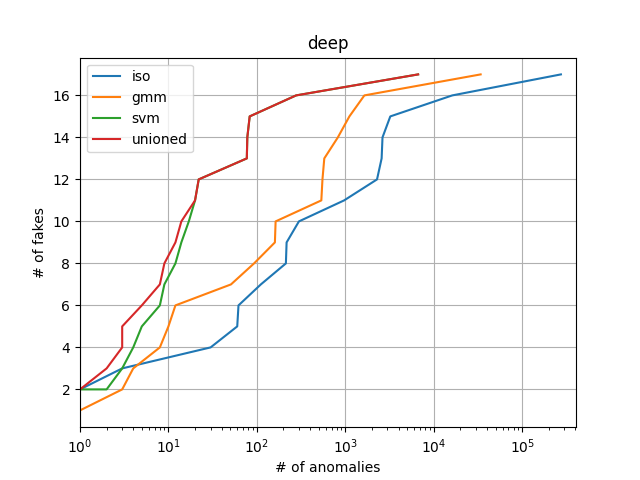

,iso,gmm,svm,union
0,step,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r,ZTF18abhjrcf_format_r
2,Gaia16aye_format_r,Gaia16aye_format_r,Gaia16aye_3_format_r,Gaia16aye_2_format_r
3,MACHO-6.6696.60_format_R,Gaia16aye_3_format_r,Gaia16aye_format_r,Gaia16aye_3_format_r
4,ZTF18abaqxrt_format_r,OGLE-LMC-CEP-0227_format_V,MACHO-6.6696.60_format_R,Gaia16aye_format_r
5,MACHO-6.6696.60_format_B,ZTF18abaqxrt_format_r,OGLE-LMC-CEP-0227_format_V,MACHO-6.6696.60_format_R
6,ZTF18aaztjyd_format_r,ZTF18abhjrcf_format_r,ZTF18abaqxrt_format_r,OGLE-LMC-CEP-0227_format_V
7,ZTF18acskgwu_format_r,MACHO-6.6696.60_format_R,MACHO-6.6696.60_format_B,ZTF18abaqxrt_format_r
8,Gaia16aye_3_format_r,ZTF18acskgwu_format_r,flat,MACHO-6.6696.60_format_B
9,OGLE-LMC-CEP-0227_format_I,OGLE-LMC-CEP-0227_format_I,ZTF18abhjrcf_format_r,flat


<IPython.core.display.Javascript object>


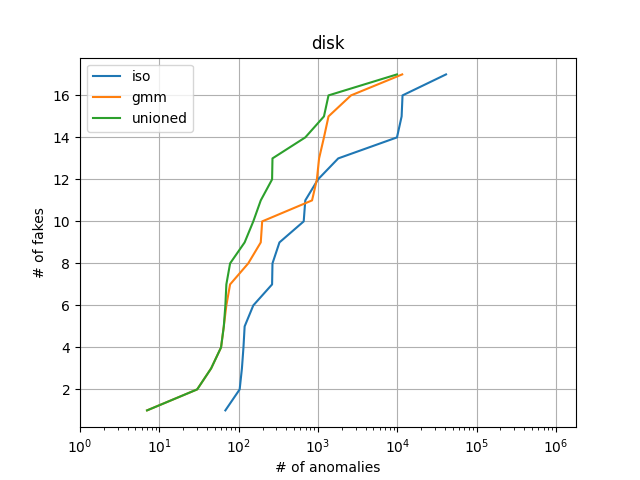

,iso,gmm,union
0,Gaia16aye_2_format_r,step,step
1,Gaia16aye_3_format_r,Gaia16aye_3_format_r,Gaia16aye_3_format_r
2,step,Gaia16aye_format_r,Gaia16aye_format_r
3,Gaia16aye_format_r,ZTF18abhjrcf_format_r,ZTF18abhjrcf_format_r
4,MACHO-6.6696.60_format_R,OGLE-LMC-CEP-0227_format_V,OGLE-LMC-CEP-0227_format_V
5,ZTF18ablruzq_format_r,ZTF18aaztjyd_format_r,Gaia16aye_2_format_r
6,ZTF18acskgwu_format_r,MACHO-6.6696.60_format_B,ZTF18aaztjyd_format_r
7,ZTF18acskgwu_format_r,MACHO-6.6696.60_format_R,MACHO-6.6696.60_format_B
8,OGLE-LMC-CEP-0227_format_V,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R
9,ZTF18abaqxrt_format_r,Gaia16aye_2_format_r,ZTF18ablruzq_format_r


In [123]:
# Build the tables, plot the figures.

algos_for_fields = {
    'm31': ['iso', 'gmm', 'svm', 'lof'],
    'deep': ['iso', 'gmm', 'svm'],
    'disk': ['iso', 'gmm'],
}

for field in algos_for_fields:
    algo_to_fakes = {}
    plt.figure()
    for algo in algos_for_fields[field]:
        scores = np.memmap('../data/scores_{}_{}_fake.dat'.format(field, algo), dtype=np.float64)
        fake_names = load_fake_names('../data/fakes/fakes_{}_fake.csv'.format(field))
        fake_table = fake_indices(scores, fake_names)
        algo_to_fakes[algo] = fake_table
        plt.plot(fake_table['order'], np.arange(len(fake_table)) + 1, label=algo)

    algo_to_fakes['union'] = union_fakes(algo_to_fakes)
    plt.plot(algo_to_fakes['union']['order'], np.arange(len(fake_table)) + 1, label='unioned')

    plt.title(field)
    plt.ylabel('# of fakes')
    plt.xlabel('# of anomalies')
    plt.xscale('log')
    plt.xlim([1, len(scores)])
    plt.legend(loc='upper left')
    plt.grid()
    
    display(pd.DataFrame({k: v['name'] for k, v in algo_to_fakes.items()}))